In [10]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices
from trial_1 import Building
from trial_1 import Area

# defines a function which imports multiple areas
def import_areas(address, distance):



In [ ]:
# defines a function which imports all buildings in an area
def import_buildings(address, distance):
    # importing osm location
    buildings = ox.features.features_from_address(address, tags={'building': True}, dist=distance)

    # creating area
    area = Area(1, address)

    # creating object for each building
    bld_lst = []
    for i in buildings.index:
        id = i[1]
        geo = buildings.loc[i, 'geometry']
        center_point = geo.centroid
        bld_function = buildings.loc[i, 'building']

        bld = Building(id, geo, center_point, bld_function)
        bld_lst.append(bld)
    return bld_lst, area

address = "Çimentepe Mahallesi"
buildings, area = import_buildings(address, 350)

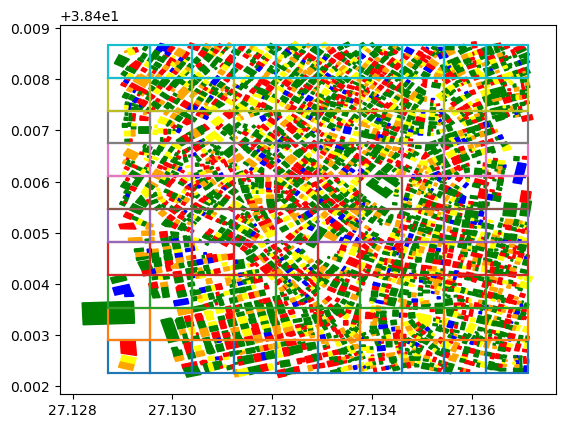

In [12]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area
from trial_1 import Area

# defines a function which generates sub_areas by dividing the boundary of all combined buildings in cells, x_steps = n of cells in x dir, y_steps = n of cells in y dir, and associating buildings with sub_areas
def generate_sub_areas(buildings, x_steps, y_steps):
    # save all the center_points of the buildings in a geodataframe
    center_points = gpd.GeoDataFrame({'points': [o.center_point for o in buildings]}, geometry = 'points')

    # set bounds of graph to the bounds of center points
    xmin, ymin, xmax, ymax = center_points.total_bounds
    x_range = xmax - xmin
    y_range = ymax - ymin

    # set stepsize
    width = x_range / x_steps
    height = y_range / y_steps

    # create cols and rows based on bounds and stepsize
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + height, height))

    # sort the list of buildings objects based on x coordinates, then y coordinates
    sorted_blds = sorted(buildings, key=lambda x: (x.center_point.x, x.center_point.y))

    # create cells and plot to graph, add buildings to subarea classes
    sub_areas = []
    i = 0
    j = 0
    for x in cols[:-1]:
        # while the buildings have x values in the range of this column, add them to a list
        filt_blds = []
        while (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
            filt_blds.append(sorted_blds[i])
            filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
            i += 1
            
        for y in rows[:-1]:
            # create a cell, sub_area object, and associate the cell with the object
            polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
            sub_area = Sub_Area(j, polygon)
            
            # while the buildings in that column have y values in the range of this row, add them to the cell object 
            while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
                sub_area.add_building(filt_blds.pop(0))
            sub_areas.append(sub_area)
            
            # add the sub_areas to the area
            area.add_sub_area(sub_area)
            
            j += 1           
    return sub_areas

sub_areas = generate_sub_areas(buildings, 10, 10)

# this code is plotting the sub_area geometry
# create empty graph and plot sub_area geometry to graph
fig, ax = plt.subplots()

for o in area.sub_areas:
    ax.plot(*o.geometry.exterior.xy)
    # print([o.sub_area_id, o.geometry, o.priority_weight, o.buildings])

# this is plotting the geometry of the buildings
# save each geometry attribute in a list
geos = [o.geometry for o in buildings]

# choices of different colours with corresponding weights
population = ['green', 'blue', 'yellow', 'orange', 'red']
weights = [0.45, 0.05, 0.15, 0.12, 0.23]

# for every geometry choose a colour, fill the geometry and plot to graph
for g in geos:
    c = choices(population, weights)[0]
    x, y = g.exterior.xy
    ax.fill(x, y, color = c)

# Display the plot
plt.show()

In [52]:
from trial_1 import Team
from trial_1 import Sub_Team
from trial_1 import Team_Member
import random

# defines a function which creates team, sub-team and team_member objects based on a number of heavy, medium and light teams in an area
def set_teams(heavy, med, light):
    # initialise amount of teams to be distributed in sector
    n_heavy = heavy
    n_med = med
    n_light = light

    # create all objects in sector and link them
    teams = []
    team_id = 0
    sub_team_id = 0
    team_member_id = 0

    # create heavy teams, subteams and teammembers
    for i in range(n_heavy):
        team = Team(team_id, 'heavy')
        for j in range(4):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(5, 10))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1

    # create medium teams, subteams and teammembers
    for i in range(n_med):
        team = Team(team_id, 'medium')
        for j in range(2):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(3, 9))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
        
    # create light teams, subteams and teammembers
    for i in range(n_light):
        team = Team(team_id, 'light')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(1, 8))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
    return teams

teams = set_teams(2, 1, 1)

# defines a function which puts all subteams in multiple teams 
def get_sub_teams(teams):
    # access and create sub_teams list
    sub_teams = []
    for tm in teams:
        for stm in tm.sub_teams:
            sub_teams.append(stm)
    return sub_teams

sub_teams = get_sub_teams(teams)
sub_team_members = [o.team_members for o in sub_teams]
print(sub_teams)
print(sub_team_members)

[<trial_1.Sub_Team object at 0x0000021D6E66D520>, <trial_1.Sub_Team object at 0x0000021D71556D30>, <trial_1.Sub_Team object at 0x0000021D71543EE0>, <trial_1.Sub_Team object at 0x0000021D715436A0>, <trial_1.Sub_Team object at 0x0000021D71543C70>, <trial_1.Sub_Team object at 0x0000021D71553670>, <trial_1.Sub_Team object at 0x0000021D715538E0>, <trial_1.Sub_Team object at 0x0000021D715534F0>, <trial_1.Sub_Team object at 0x0000021D715533D0>, <trial_1.Sub_Team object at 0x0000021D6EDBE7C0>, <trial_1.Sub_Team object at 0x0000021D6EDBE700>]
[[<trial_1.Team_Member object at 0x0000021D6E66D790>, <trial_1.Team_Member object at 0x0000021D6EF53040>, <trial_1.Team_Member object at 0x0000021D71556F40>, <trial_1.Team_Member object at 0x0000021D71556EE0>, <trial_1.Team_Member object at 0x0000021D71556E80>, <trial_1.Team_Member object at 0x0000021D71556D90>], [<trial_1.Team_Member object at 0x0000021D71556C70>, <trial_1.Team_Member object at 0x0000021D71556BE0>, <trial_1.Team_Member object at 0x0000021

In [58]:
# defines a function which allocates sub_teams to sub_areas based on priority weight and competence, at start of allocating
def sort_priority_competence(sub_areas, sub_teams):
    # sorts the sub_areas so that the sub_areas with the highest priority weight are first in the list
    sub_areas = sorted(sub_areas, key=lambda x: (x.priority_weight), reverse=True)

    # sorts the sub_teams so that the sub_teams with the highest competence are first in the list
    sub_teams = sorted(sub_teams, key=lambda x: (x.competence), reverse=True)
    return sub_areas, sub_teams

# sort the sub_areas and sub_teams lists
sub_areas, sub_teams = sort_priority_competence(sub_areas, sub_teams)
print([o.priority_weight for o in sub_areas])
print([o.competence for o in sub_teams])
print(sub_areas)

# defines a function which allocates sub_team(s) to sub_area(s) based on priority weight and competence, works with sub_teams list or single object
def allocate_sub_team(sub_areas, sub_teams):
    rem_sub_areas = sub_areas
    # links the objects of sub_teams to sub_areas and removes the sub_areas that are allocated from the sub_areas list
    if hasattr(sub_teams, '__iter__'):
        for i, o in enumerate(sub_teams):
            o.assign_sub_area(rem_sub_areas.pop(0))
    else:
        sub_teams.assign_sub_area(rem_sub_areas.pop(0))
    return rem_sub_areas

# allocate all teams during start
rem_sub_areas = allocate_sub_team(sub_areas, sub_teams)
print(len(rem_sub_areas))

# allocate a team after the team cleared a sub_area
rem_sub_areas = allocate_sub_team(rem_sub_areas, sub_teams[0])
print(len(rem_sub_areas))
print(len(sub_areas))

# WHY DOES IT KEEP REMOVING ITEMS FROM THE sub_areas LIST, VARIABLES IN A FUNCTION SHOULD BE LOCAL???

[52.73913043478261, 52.735849056603776, 52.666666666666664, 52.25, 52.08, 51.9375, 51.0, 50.94736842105263, 50.875, 50.8, 50.78846153846154, 50.729729729729726, 50.54761904761905, 50.54237288135593, 49.60606060606061, 49.361702127659576, 49.31481481481482, 49.22222222222222, 49.104166666666664, 48.98148148148148, 48.9622641509434, 48.86, 48.69565217391305, 48.63636363636363, 48.196969696969695, 48.186440677966104, 48.0, 47.88461538461539, 47.833333333333336, 47.755102040816325, 47.68181818181818, 47.666666666666664, 47.48571428571429, 47.37777777777778, 47.25925925925926, 47.24561403508772, 46.97560975609756, 46.93333333333333, 46.8125, 46.68852459016394, 46.628571428571426, 46.625, 46.595238095238095, 46.58139534883721, 46.48979591836735, 46.43589743589744, 46.2, 46.0, 45.827586206896555, 45.74, 45.71739130434783, 45.64102564102564, 45.61224489795919, 45.23809523809524, 45.15217391304348, 44.96153846153846, 44.294117647058826, 44.15, 42.4, 42.0, 41.86206896551724, 41.84848484848485, 4

In [ ]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()